# Poverty & Wealth Mapping


"Despite decades of declining poverty rates, an estimated 8.4% of the global population remains in extreme poverty as of 2019, and progress has slowed in recent years [1]. But data on poverty remain surprisingly sparse, hampering efforts at monitoring local progress, targeting aid to those who need it, and evaluating the effectiveness of antipoverty programs [2]. Previous works [3,4] have demonstrated using computer vision on satellite images and street-level images to predict economic livelihood." [5]

In this notebook, we will pull a 2021 benchmark dataset from the Stanford Sustainability and AI Lab called "SustainBench". This dataset contains a variety of datasets related to sustainability, including datasets related to poverty and wealth mapping. More info on it can be found on the [project website](https://sustainlab-group.github.io/sustainbench/), the [GitHub repo](https://github.com/sustainlab-group/sustainbench), or the [arXiv paper](https://arxiv.org/abs/2111.04724). The data comes from surveys collected by the [Demographic and Health Surveys (DHS) Program](https://dhsprogram.com/) from USAID (RIP 😢). Nationally represenative surveys are conducted every few years in dozens of low- and middle-income countries (LMICs) around the world. Surveyors will go out to urban neigborhoods or rural communities and survey a few dozen random households within that "cluster". The anonymized household level data is geotagged with the coordinates of the cluster with a jitter to further protect privacy. The jitter is within a 2km radius for urban clusters, and a 5km radius for rural clusters. We will focus on Task 1A from SustainBench, mapping wealth and poverty spatially. SustainBench has made our lives easier by collating this data for 80k+ clusters and making it publicly avaiable, but you can request the original and latest household-level data directly from the [DHS on their website](https://dhsprogram.com/data/available-datasets.cfm), it takes just a couple of days to get approved.

![sustainbench](https://sustainlab-group.github.io/sustainbench/assets/images/sdg1_summary.png)


We then will pull in 3 geospatial foundation models that use three different architectures:
1. [CLAY](https://madewithclay.org/) (pre-trained with a masked autoencoder)
2. [SatCLIP](https://github.com/microsoft/satclip) (pre-trained with contrastive learning)
3. [MOSAIKS](https://www.mosaiks.org/) (random convolutional features)

We will then use these models to extract features from the poverty and wealth mapping dataset, and then train a linear classifier on top of these features to predict the poverty and wealth labels. We will then evaluate the performance of each model on the test set.

### References

[1] United Nations Department of Economic and Social Affairs. The Sustainable Development Goals Report 2021. The Sustainable Development Goals Report. United Nations, 2021 edition, 2021. ISBN 978-92-1-005608-3. doi: 10.18356/9789210056083. URL https://www.un-ilibrary.org/content/books/9789210056083.

[2] M. Burke, A. Driscoll, D. B. Lobell, and S. Ermon. Using satellite imagery to understand and promote sustainable development. Science, 371(6535), 2021. doi: 10.1126/science.448abe8628. URL https://www.science.org/doi/10.1126/science.abe8628.

[3] C. Yeh, A. Perez, A. Driscoll, G. Azzari, Z. Tang, D. Lobell, S. Ermon, and M. Burke. Using publicly available satellite imagery and deep learning to understand economic well-being in Africa. Nature Communications, 11(1), 5 2020. ISSN 2041-1723. doi: 10.1038/s41467-020-58916185-w. URL https://www.nature.com/articles/s41467-020-16185-w.

[4] J. Lee, D. Grosz, B. Uzkent, S. Zeng, M. Burke, D. Lobell, and S. Ermon. Predicting Livelihood Indicators from Community-Generated Street-Level Imagery. Proceedings of the AAAI Conference on Artificial Intelligence, 35(1):268–276, 5 2021. ISSN 2374-3468. URL https://ojs.aaai.org/index.php/AAAI/article/view/16101.

[5] C. Yeh, C. Meng, S. Wang, A. Driscoll, E. Rozi, P. Liu, J. Lee, M. Burke, D. Lobell, and S. Ermon, “SustainBench: Benchmarks for Monitoring the Sustainable Development Goals with Machine Learning,” in Thirty-fifth Conference on Neural Information Processing Systems, Datasets and Benchmarks Track (Round 2), Dec. 2021. [Online]. Available: https://openreview.net/forum?id=5HR3vCylqD.

## Environment Setup

In [ ]:
# install any libraries that are missing
# !pip install geopandas
# !pip install lonboard

In [1]:
# import necessary libraries
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import torch
from lonboard import viz

# set the random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("imported")


imported


## Read in and Visualize Dataset
Every good data scientists knows that you need to visualize your data to understand it.

In [2]:
# read in the csv file
df = pd.read_csv("~/code/ai4good/data/wk5/dhs_final_labels.csv")

# now convert this regular dataframe into a nifty geopandas dataframe
# learn more about what a "geo" dataframe is here: https://geopandas.org/en/stable/docs/user_guide/data_structures.html#geodataframe
# it's based on Python Shapely geometries: https://shapely.readthedocs.io/en/stable/geometry.html
# which is in turn based on C/C++ GEOS geometries: https://libgeos.org/usage/
# which is in turn based on the OGC Simple Features standard: https://en.wikipedia.org/wiki/Simple_Features
# which describes well-known text (WKT) representations of vector geometry: https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry
# fun!
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326")
gdf.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,n_under5_mort,women_edu,women_bmi,n_women_edu,n_women_bmi,cluster_id,adm1fips,adm1dhs,urban,geometry
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,6.0,9.500000,24.365000,18.0,18.0,1,NaN,9999,R,POINT (19.83832 40.82265)
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,NaN,8.600000,23.104000,20.0,20.0,2,NaN,9999,R,POINT (20.00755 40.69685)
2,AL-2008-5#-00000003,AL,2008,40.750037,19.974262,18.0,2.909049,18.0,4.500000,18.0,...,NaN,9.666667,22.387778,18.0,18.0,3,NaN,9999,R,POINT (19.97426 40.75004)
3,AL-2008-5#-00000004,AL,2008,40.798931,19.863338,19.0,2.881122,19.0,4.947368,19.0,...,NaN,9.952381,27.084500,21.0,20.0,4,NaN,9999,R,POINT (19.86334 40.79893)
4,AL-2008-5#-00000005,AL,2008,40.746123,19.843885,19.0,2.546830,19.0,4.684211,19.0,...,6.0,8.937500,24.523125,16.0,16.0,5,NaN,9999,R,POINT (19.84389 40.74612)


In [3]:
# visualize with lonboard from Development Seed built on top of deck.gl
# learn more about it at https://github.com/developmentseed/lonboard or in the documentation here https://developmentseed.org/lonboard/latest/
# hover over the points to see the data labels
viz(gdf)

Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

That's a lot of clusters! Thanks `lonboard` for loading it all so quickly. What are some countries missing from this dataset? Why do you think DHS didn't include them? Could this lead to potential biases? 🤔

## Geospatial Foundation Models
Since we aren't going to be doing any training in this notebook, we don't need the inputs from SustainBench, we'll just use the labels. Each of the foundation models that we're going to be using can take in a given lat/long and return a vector of embeddings. Let's fetch those embeddings for each of the clusters in our dataset one model at a time.

### CLAY
https://clay-foundation.github.io/model/index.html

### MOSAIKS
MULTI-TASK OBSERVATION USING SATELLITE IMAGERY & KITCHEN SINKS
Nature Paper: https://www.nature.com/articles/s41467-021-24638-z
Website with API: https://api.mosaiks.org/portal/index/

In [ ]:
# import os
# import requests
# from tqdm import tqdm

# # Cookie for authentication
# COOKIE = {
#     "csrftoken": "I9x2jvGGE4se3MBa9moavDtC9o8YEgaA4Rup5ijhHJjCTRn0qRpHGJW06XG0SooG",
#     "sessionid": "y44nlmh7rjrqvvxj902jc8pmw918m1p7",
# }

# # Base URL for file downloads
# BASE_URL = "https://api.mosaiks.org/portal/download_grid_file/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True"

# # Destination directory
# DEST_DIR = "/Users/isaiah/code/ai4good/data/wk5/mosaiks"
# os.makedirs(DEST_DIR, exist_ok=True)  # Ensure the directory exists

# # Regions and chunks to download
# regions = {
#     # "Africa": [1, 2, 3],
#     # "Asia": [1, 2, 3, 4, 5, 6],
#     # "Europe": [1, 2],
#     # "North America": [1, 2, 3],
#     "Oceania": [1],
#     # "South America": [1, 2],
#     "Australia": [1],
# }

# # Function to download a file with progress bar
# def download_file(url, filename):
#     response = requests.get(url, cookies=COOKIE, stream=True, verify=False)
    
#     if response.status_code == 200:
#         total_size = int(response.headers.get("content-length", 0))
#         with open(filename, "wb") as f, tqdm(
#             desc=os.path.basename(filename),
#             total=total_size,
#             unit="B",
#             unit_scale=True,
#             unit_divisor=1024,
#         ) as bar:
#             for chunk in response.iter_content(1024):
#                 f.write(chunk)
#                 bar.update(len(chunk))
#         print(f"✅ Downloaded: {filename}")
#     else:
#         print(f"❌ Failed to download {url} (Status {response.status_code})")

# # Download each file
# for region, chunks in regions.items():
#     for chunk in chunks:
#         filename = os.path.join(DEST_DIR, f"{region.lower()}_{chunk}.zip")
#         url = f"{BASE_URL}/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_{region}_chunk={chunk}.zip"
#         if (region == "Australia" or region == "Oceania"):
#             url = f"{BASE_URL}/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_{region}.zip"
        
#         print(f"📥 Downloading {url}...")
#         download_file(url, filename)


In [7]:
# unzip the files
import zipfile
import os
import glob

# Define the directory containing the zip files
zip_dir = "/Users/isaiah/code/ai4good/data/wk5/mosaiks100"
# Define the directory to extract the contents
extract_dir = "/Users/isaiah/code/ai4good/data/wk5/mosaiks100/"
# Create the extraction directory if it doesn't exist
os.makedirs(extract_dir, exist_ok=True)
# Loop through all zip files in the directory
for zip_file in glob.glob(os.path.join(zip_dir, "*.zip")):
    # Open the zip file
    with zipfile.ZipFile(zip_file, "r") as z:
        # Extract all the contents into the extraction directory
        z.extractall(extract_dir)
        print(f"Extracted {zip_file} to {extract_dir}")


Extracted /Users/isaiah/code/ai4good/data/wk5/mosaiks100/coarsened_global_dense_grid_decimal_place=0_GHS_pop_weight=True.zip to /Users/isaiah/code/ai4good/data/wk5/mosaiks100/


In [1]:
# # replace all " " in the filenames with "_"
# import os
# import glob
# import shutil
# import re

# # Define the directory containing the files
# directory = "/Users/isaiah/code/ai4good/data/wk5/mosaiks/"
# # Loop through all files in the directory
# for filename in glob.glob(os.path.join(directory, "*")):
#     # Replace spaces with underscores
#     new_filename = re.sub(r"\s+", "_", filename)
#     # Rename the file
#     os.rename(filename, new_filename)
#     print(f"Renamed {filename} to {new_filename}")

Renamed /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=2.csv to /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=2.csv
Renamed /Users/isaiah/code/ai4good/data/wk5/mosaiks/europe_2.zip to /Users/isaiah/code/ai4good/data/wk5/mosaiks/europe_2.zip
Renamed /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=3.csv to /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=3.csv
Renamed /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=1.csv to /Users/isaiah/code/ai4good/data/wk5/mosaiks/coarsened_global_dense_grid_decimal_place=1_GHS_pop_weight=True_Africa_chunk=1.csv
Renamed /Users/isaiah/code/ai4good/data/wk5/mosaiks/europe_1.zip to /Users/isaia

In [ ]:
# # combine the csv files into one for each continent
# import pandas as pd
# import os
# import glob

# # Define the directory containing the CSV files
# csv_dir = "/Users/isaiah/code/ai4good/data/wk5/mosaiks/"
# # Define the output directory for the combined CSV files
# output_dir = "/Users/isaiah/code/ai4good/data/wk5/mosaiks/"
# # Create the output directory if it doesn't exist
# os.makedirs(output_dir, exist_ok=True)
# # Loop through each continent
# for continent in ["Europe", "North_America", "South_America", "Oceania", "Asia"]:
#     print(f"Combining {continent} files...")
#     # Find all CSV files for the continent
#     csv_files = glob.glob(os.path.join(csv_dir, f"*{continent}_*.csv"))
#     # Combine the CSV files into one DataFrame
#     print(f"Combining {len(csv_files)} files...")
#     combined_df = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)
#     # Save the combined DataFrame to a new CSV file
#     combined_df.to_csv(os.path.join(output_dir, f"{continent}.csv"), index=False)
#     print(f"Combined {len(csv_files)} files into {continent}.csv")

### Prepare Data to Merge with MOSAIKS Embeddings
Now we need to match up our locations with the MOSAIKS locations.

In [27]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("~/code/ai4good/data/wk5/dhs_final_labels.csv")

# Assign coordinates to nearest tile centroid
df["Lon"] = round(round(df["lon"] + 0.5, 0) - 0.5, 1)
df["Lat"] = round(round(df["lat"] + 0.5, 0) - 0.5, 1)

# drop rows that have a NaN for asset_index
df = df.dropna(subset=["asset_index"])

# keep just one row for every unique Lat, Lon combination
before_len = len(df)
df = df.drop_duplicates(subset=["Lat", "Lon"], keep="first")
print(f"Started with {before_len} rows, now have {len(df)} rows")

# Convert to GeoDataFrame
df_gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["Lon"], df["Lat"]), crs="EPSG:4326")

# Write to CSV
df_gdf.to_csv("~/code/ai4good/data/wk5/mosaiks100/dhs_final_labels_centered_1_deg.csv", index=False)

# visualize it, it should appear gridded to 1 degree now
viz(df_gdf)

Started with 86936 rows, now have 2167 rows


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [28]:
# read in the MOSAIKS embeddings
mosaiks = pd.read_csv("~/code/ai4good/data/wk5/mosaiks100/coarsened_global_dense_grid_decimal_place=0_GHS_pop_weight=True.csv")
df = pd.read_csv("~/code/ai4good/data/wk5/mosaiks100/dhs_final_labels_centered_1_deg.csv")

# merge the two dataframes on the Lat, Lon columns from the labels and the lat, lon columns from the mosaiks
mosaiks = mosaiks.rename(columns={"lat": "Lat", "lon": "Lon"})
df = df.merge(mosaiks, on=["Lat", "Lon"], how="left")

# save this as a csv
df.to_csv("~/code/ai4good/data/wk5/mosaiks100/dhs_final_labels_centered_1_deg_with_mosaiks.csv", index=False)

# inspect the data
df.head()

,DHSID_EA,cname,year,lat,lon,n_asset,asset_index,n_water,water_index,n_sanitation,...,X_3990,X_3991,X_3992,X_3993,X_3994,X_3995,X_3996,X_3997,X_3998,X_3999
0,AL-2008-5#-00000001,AL,2008,40.822652,19.838321,18.0,2.430596,18.0,3.444444,18.0,...,0.568857,0.381831,1.045471,0.784813,0.468075,1.423943,2.497631,0.908302,0.881394,0.249681
1,AL-2008-5#-00000002,AL,2008,40.696846,20.007555,20.0,2.867678,20.0,4.700000,20.0,...,0.462804,0.256797,0.826575,0.591551,0.388425,1.305228,2.211356,0.866921,0.755176,0.187631
2,AL-2008-5#-00000016,AL,2008,41.491808,20.192569,18.0,3.124491,18.0,5.000000,18.0,...,0.488216,0.312046,0.926325,0.674331,0.403479,1.329788,2.349097,0.904745,0.755452,0.231837
3,AL-2008-5#-00000033,AL,2008,39.938528,20.079233,15.0,2.725657,15.0,4.600000,15.0,...,0.570869,0.308572,0.977717,0.686575,0.485997,1.457712,2.581809,0.970307,0.874068,0.216238
4,AL-2008-5#-00000065,AL,2008,41.330760,19.579645,18.0,2.814022,18.0,4.277778,18.0,...,0.571309,0.430136,1.127487,0.845187,0.487944,1.419822,2.473511,0.844127,0.877452,0.259263


## Run Linear Classifier using Ridge Regression
Now that we have our embeddings and our labels, we can run a linear classifier on top of the embeddings to see how well each model does at predicting poverty and wealth. We will use Ridge regression to do this, since it is a linear model that can handle high dimensional data well. It uses L2 regularization to prevent overfitting, penalizing large weights. You can learn more about it in [this Medium post](https://medium.com/@msoczi/ridge-regression-step-by-step-introduction-with-example-0d22dddb7d54) or in this tutorial from [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/01/ridge-lasso-regression-python-complete-tutorial/).

In [63]:
# read in the data
df = pd.read_csv("~/code/ai4good/data/wk5/mosaiks100/dhs_final_labels_centered_1_deg_with_mosaiks.csv")

# keep just the columns we need
df = df[[col for col in df.columns if col.startswith("X_")] + ["asset_index"]]
# check for NaNs
print("Number of NaNs in df: ", df.isna().sum())
# drop rows with NaNs
df = df.dropna()
# check the shape again
print("Shape of df: ", df.shape)

# create a train/val/test split of 80/10/10
from sklearn.model_selection import train_test_split

# split the data into train and test sets
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
# split the test set into val and test sets
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)
# check the shapes of the data
print("Shape of df_train: ", df_train.shape)
print("Shape of df_val: ", df_val.shape)
print("Shape of df_test: ", df_test.shape)


# separate the data into X and y
y_train = df_train["asset_index"]
y_val = df_val["asset_index"]
y_test = df_test["asset_index"]

# x is all the data in columns with names formatted like "X_1"
X_train = df_train[[col for col in df.columns if col.startswith("X_")]]
X_val = df_val[[col for col in df.columns if col.startswith("X_")]]
X_test = df_test[[col for col in df.columns if col.startswith("X_")]]


Number of NaNs in df:  X_0            1
X_1            1
X_2            1
X_3            1
X_4            1
              ..
X_3996         1
X_3997         1
X_3998         1
X_3999         1
asset_index    0
Length: 4001, dtype: int64
Shape of df:  (2166, 4001)
Shape of df_train:  (1732, 4001)
Shape of df_val:  (217, 4001)
Shape of df_test:  (217, 4001)


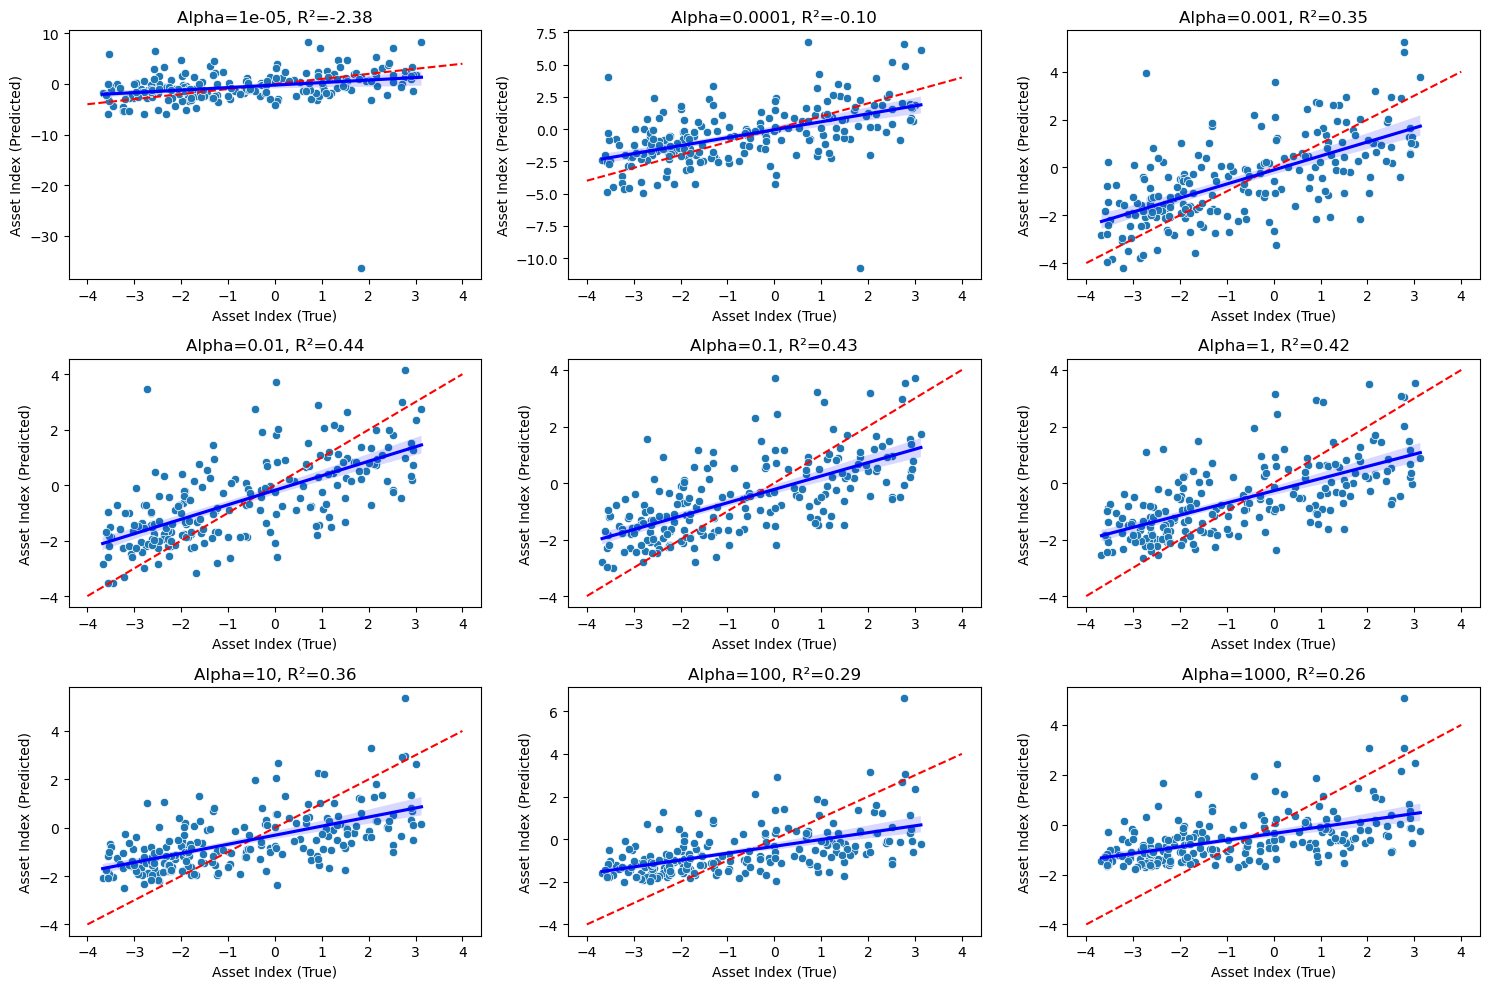

In [87]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Define alpha values to loop over
alpha_values = [10**i for i in range(-5, 4)]  # Corrected alpha values from 0.001 to 1000

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.ravel()

for i, alpha in enumerate(alpha_values):
    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    r2 = r2_score(y_val, y_pred)
    
    # Create scatter plot using Seaborn
    sns.scatterplot(x=y_val, y=y_pred, ax=axes[i])
    axes[i].plot([-4, 4], [-4, 4], "r--")  # 45-degree line
    
    # Fit a regression line with confidence interval
    sns.regplot(x=y_val, y=y_pred, ax=axes[i], scatter=False, ci=95, line_kws={"color": "blue"})
    
    axes[i].set_title(f"Alpha={alpha}, R²={r2:.2f}")
    axes[i].set_xlabel("Asset Index (True)")
    axes[i].set_ylabel("Asset Index (Predicted)")

plt.tight_layout()
plt.show()

What do you see happening in the plots above? Answer the following questions:
1. What's going on with the small alpha values? Why are most data points squished up towards the top? Why is there such a strong outlier?
2. What do you think is going on with the large alpha values? Why does the R-squared value decrease again? 
3. The red line shows a 45-degree line of a theoretical perfect fit. The blue line shows an approximation of the actual fit. Why is the blue line consistently flatter than the red line? What does this mean for our model? How could we improve that?

## To Do
- [ ] Get the precise embeddings from the MOSAIKS folks
- [ ] Work with the 1.0 degrees for now
- [ ] Join the MOSAIKS embeddings with the SustainBench data
- [ ] Run Ridge regression on the MOSAIKS embeddings with poverty as the label
- [ ] Report on the results
- [ ] Compare with CLAY and SatCLIP